# Determining the age of customers

### Project Description
The chain supermarket "Bread-Salt" introduces a computer vision system for processing customer photos. Photo fixation in the checkout area will help determine the age of customers in order to:
- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Monitor the integrity of cashiers when selling alcohol.

Build a model that can determine the approximate age of a person from a photo. At your disposal is a set of photos of people with age indication.

Data taken from the site <a href="http://chalearnlap.cvc.uab.es/dataset/26/description /">ChaLearn Looking at People</a><br>

<b>Task</b><br>
Build and train a convolutional neural network on a dataset with photos of people. Achieve the MAE value on the test sample no more than 8. In the article about the dataset you are working with, the value of MAE is 5.4 — if you get MAE less than 7, it will be a great result!

## ETL

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data = pd.read_csv('/datasets/faces/labels.csv', sep=',')

In [5]:
data.shape

(7591, 2)

In [7]:
len(data['real_age'].unique())

97

There are 97 unique ages, but perhaps there are just ages that do not occur. Let's see the min max age

In [8]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Indeed, there are 97 unique ones, and the range is from 1 to 100. Therefore, we make 100 bins.

<AxesSubplot:>

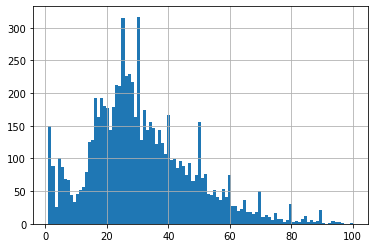

In [9]:
data['real_age'].hist(bins=100)

You can also explicitly set baskets, but we understand that we will not have some baskets and we will not see zeros.

<AxesSubplot:>

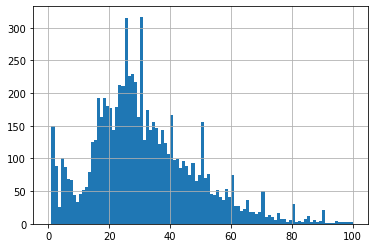

In [13]:
data['real_age'].hist(bins=[0]+sorted(data['real_age'].unique()))

In [14]:
data.head(15)['file_name']

0     000000.jpg
1     000001.jpg
2     000002.jpg
3     000003.jpg
4     000004.jpg
5     000005.jpg
6     000006.jpg
7     000007.jpg
8     000008.jpg
9     000009.jpg
10    000010.jpg
11    000011.jpg
12    000012.jpg
13    000013.jpg
14    000014.jpg
Name: file_name, dtype: object

In [2]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# перенес

In [15]:
datagen = ImageDataGenerator(rescale=1/255.) 

In [16]:
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data, 
    directory='/datasets/faces/final_files', 
    x_col='file_name', 
    y_col='real_age', 
    #weight_col=None, 
    target_size=(256, 256), 
    #color_mode=’rgb’, 
    #classes=None, 
    class_mode='raw', 
    batch_size=16, 
    #shuffle=True, 
    seed=12345, 
    #save_to_dir=None, 
    #save_prefix=», 
    #save_format=’png’, 
    #subset=None, 
    #interpolation=’nearest’, 
    #validate_filenames=True
)
images = next(datagen_flow)

Found 7591 validated image filenames.


In [17]:
images[0].shape

(16, 256, 256, 3)

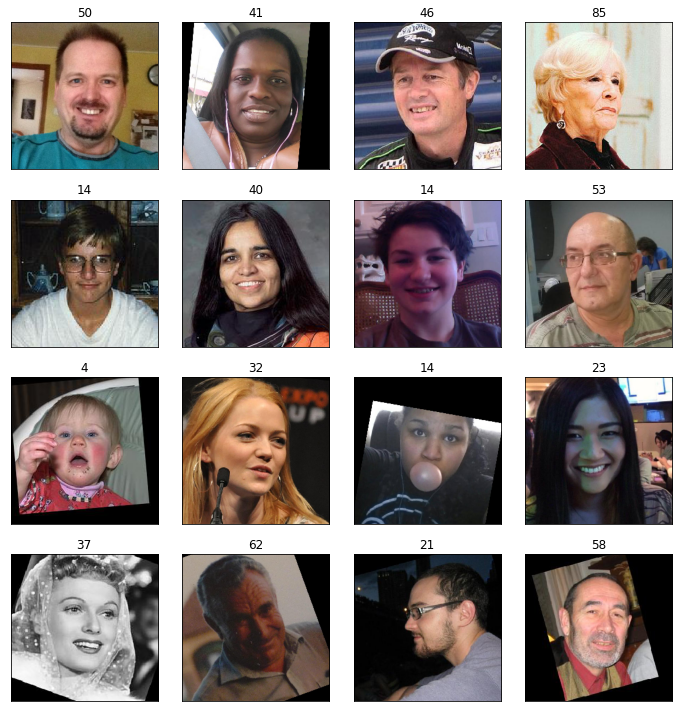

In [18]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images[0][i])
    # for compactness, we remove the axes and place the images close each to other
    plt.title(images[1][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


### CONCLUSIONS

The photos have a plausible markup, the age of people is approximately similar to the one in the target<br>
The sample size of 7591 photos is certainly not super huge, but large enough to build a model<br>
With the model, you will need to apply augmentation, because photos of people from different angles (the face is turned left or right, the photos themselves are turned sometimes<br>
Most of the people in this set are between 10 and 40 years old.<br>
Judging by the histogram, there are peaks at ages multiples of 5 years. Perhaps the markup was done by people and roughly rounded up the age. There is also a failure of people about 10 years old, probably this is due either to the method of collecting photos that cut off teenagers, or some legal modet restrictions on the use of photos of minors...


## Model Training

Transfer the training code of the model and its output to the screen here.


(The code in this section runs in a separate GPU simulator, so it is designed not as a cell with a code, but as a code in a text cell)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    #model.summary()
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 89 steps, validate for 30 steps
Epoch 1/10
2022-08-16 21:51:44.833999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-16 21:51:45.318215: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-16 21:51:48.015766: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-08-16 21:51:48.015832: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
89/89 - 64s - loss: 211.7584 - mae: 10.5230 - val_loss: 567.8131 - val_mae: 18.8161
Epoch 2/10
89/89 - 43s - loss: 67.6485 - mae: 6.2195 - val_loss: 533.1703 - val_mae: 18.0413
Epoch 3/10
89/89 - 43s - loss: 36.6590 - mae: 4.5950 - val_loss: 544.4178 - val_mae: 18.2884
Epoch 4/10
89/89 - 45s - loss: 22.5421 - mae: 3.6192 - val_loss: 557.1848 - val_mae: 18.5305
Epoch 5/10
89/89 - 43s - loss: 15.7481 - mae: 3.0501 - val_loss: 511.8022 - val_mae: 17.3992
Epoch 6/10
89/89 - 41s - loss: 12.2467 - mae: 2.6928 - val_loss: 354.1048 - val_mae: 13.8400
Epoch 7/10
89/89 - 41s - loss: 9.0527 - mae: 2.3284 - val_loss: 196.1084 - val_mae: 10.2718
Epoch 8/10
89/89 - 42s - loss: 7.5515 - mae: 2.1351 - val_loss: 133.7147 - val_mae: 8.5628
Epoch 9/10
89/89 - 42s - loss: 6.8691 - mae: 1.9992 - val_loss: 98.8360 - val_mae: 7.5028
Epoch 10/10
89/89 - 44s - loss: 6.7299 - mae: 1.9763 - val_loss: 82.3445 - val_mae: 6.7233

```

## Analysis of the trained model

The model showed a good result, however, there is a feeling that this is not the limit, you can try to change the augmentation, the learning rate of Adam, as well as increase the number of epochs, because it will probably be possible to improve the metric even more
